In [1]:
%matplotlib inline
import pylab as pl
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from astropy import visualization
from astroplan.plots import plot_finder_image
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier

pl.rcParams['image.origin'] = 'lower' # make images display right-side-up
pl.style.use('dark_background')
os.chdir("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 1\\AST3722-Fall-2021-09-29-21")

## Darks

Importing in darks, turning into a time series, creating a master variable  with the median values of the darks. We do the median instead of the mean because the median is not skewed by outliers in the data

In [2]:
## 40 ms darks -- biases
biases = glob.glob("Darks\\dark_40ms*.FIT")
bias_timesearies = np.array([fits.getdata(fn) for fn in biases])
master_bias = np.median(bias_timesearies, axis=0)

# 20 s darks
dark_20s = glob.glob("Darks\\dark_20s*.FIT")
dark_20s_timeseries = np.array([fits.getdata(fn) for fn in dark_20s])
master_dark_20s = np.median(dark_20s_timeseries, axis=0) 

# 30 s darks
dark_30s = glob.glob("Darks\\dark_30s*.FIT")
dark_30s_timeseries = np.array([fits.getdata(fn) for fn in dark_30s])
master_dark_30s = np.median(dark_30s_timeseries, axis=0) 

## Finding the mean, standard deviation, and readnoise of the bias 
bias_timestream = [fits.getdata(x)*fits.getheader(x)['EGAIN'] for x in biases]
mean_bias = np.mean(bias_timestream, axis=0)
stddev_bias = np.std(bias_timestream, axis=0)
readnoise = np.mean(stddev_bias)
del bias_timestream

## mean of the bias noise is the readnoise / sqrt of how many biases their are
mean_bias_noise = readnoise / np.sqrt(len(biases))
mean_bias_noise

6.321659545083941

In [3]:
readnoise

14.13566047341809

In [4]:
## Finding the mean of the 20s frame
gain = fits.getheader("Twighlight Flats\\flat_15s_Clear001.FIT")['EGAIN']

mean_frame20s = np.mean(master_dark_20s - master_bias)*gain
mean_frame20s # units of electrons per pixle 

# divide by the exposure time to get units of per second 
dark_current20s = mean_frame20s/20
print("Dark Current 20s", dark_current20s) ## units of electrons per pixle per second

##Finding dark current for 30 seconnd frame 
mean_frame30s = np.mean(master_dark_30s - master_bias)*gain

## divide by the exposure time to get units of per second 
dark_current30s = mean_frame30s/30
print("Dark Current 30s",dark_current30s) ## units of electrons per pixle per second

Dark Current 20s 0.0794830385749071
Dark Current 30s 0.5306858601392627


In [5]:
## readnoise in units electrons per pixel 
# readnoise - uncertainty on bias frames 
readnoise

14.13566047341809

## Photometry Zero Point

In [6]:
M13_darksub_C_flattened = fits.getdata('M13_20s_Clear001_darksub_flattened.fits')
M13_darksub_C_flattened_uncertainty = fits.getdata('M13_20s_Clear001_darksub_flattened_uncertainty.fits')

M13_darksub_B_flattened = fits.getdata('M13\\darksub_flattened_M13_V.FIT')
M13_darksub_B_flattened_uncertainty = fits.getdata('M13_20s_V001_darksub_flattened_uncertainty.fits')

M13_darksub_V_flattened = fits.getdata('M13\\darksub_flattened_M13_B.FIT')
M13_darksub_V_flattened_uncertainty = fits.getdata('M13_20s_B001_darksub_flattened_uncertainty.fits')

#M13_darksub_B_flattened = fits.getdata('M13\\darksub_flattened_M13_B.FIT')
#M13_darksub_B_flattened_uncertainty = fits.getdata('M13_20s_B001_darksub_flattened_uncertainty.fits')

M13_darksub_I_flattened = fits.getdata('M13\\darksub_flattened_M13_I.FIT')
M13_darksub_I_flattened_uncertainty = fits.getdata('M13_20s_I003_darksub_flattened_uncertainty.fits')

#M13_darksub_V_flattened = fits.getdata('M13\\darksub_flattened_M13_V.FIT')
#M13_darksub_V_flattened_uncertainty = fits.getdata('M13_20s_V001_darksub_flattened_uncertainty.fits')

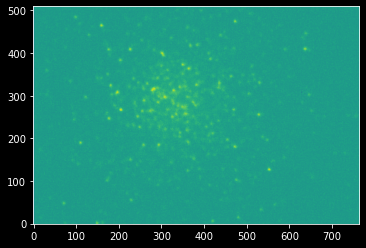

In [7]:
pl.imshow(M13_darksub_V_flattened)

In [8]:
sky_mean_c = M13_darksub_C_flattened.mean()
sky_median_c = np.median(M13_darksub_C_flattened)
print("Clear:", sky_mean_c, sky_median_c)

sky_mean_B = M13_darksub_B_flattened[50:100,650:700].mean()
sky_median_B = np.median(M13_darksub_B_flattened[50:100,650:700])
print("B:", sky_mean_B, sky_median_B)

sky_mean_I = M13_darksub_I_flattened[50:100,650:700].mean()
sky_median_I = np.median(M13_darksub_I_flattened[50:100,650:700])
print("I:", sky_mean_I, sky_median_I)

sky_mean_V = M13_darksub_V_flattened[50:100,650:700].mean()
sky_median_V = np.median(M13_darksub_V_flattened[50:100,650:700])
print("V:", sky_mean_V, sky_median_V)

Clear: 770.7818516752839 698.2592005869254
B: 71.52849498172148 71.86332096150136
I: 62.71065821588145 62.313142874245294
V: 74.5897901371412 74.66264549818924


In [9]:
sky_stddev_C = M13_darksub_C_flattened.std() # estimate of the per-pixel error
print(f"Standard deviation of the data for B: {sky_stddev_C:0.1f}")
print(f"Average of the per-pixel uncertainty from error propagation: {M13_darksub_C_flattened_uncertainty.mean():0.1f}")

sky_stddev_B = M13_darksub_B_flattened.std() # estimate of the per-pixel error
print(f"Standard deviation of the data for B: {sky_stddev_B:0.1f}")
print(f"Average of the per-pixel uncertainty from error propagation: {M13_darksub_B_flattened_uncertainty.mean():0.1f}")

sky_stddev_V = M13_darksub_V_flattened.std() # estimate of the per-pixel error
print(f"Standard deviation of the data for B: {sky_stddev_V:0.1f}")
print(f"Average of the per-pixel uncertainty from error propagation: {M13_darksub_V_flattened_uncertainty.mean():0.1f}")

sky_stddev_I = M13_darksub_I_flattened.std() # estimate of the per-pixel error
print(f"Standard deviation of the data for I: {sky_stddev_I:0.1f}")
print(f"Average of the per-pixel uncertainty from error propagation: {M13_darksub_I_flattened_uncertainty.mean():0.1f}")

Standard deviation of the data for B: 293.8
Average of the per-pixel uncertainty from error propagation: 31.3
Standard deviation of the data for B: 24.4
Average of the per-pixel uncertainty from error propagation: 20.8
Standard deviation of the data for B: 20.9
Average of the per-pixel uncertainty from error propagation: 17.3
Standard deviation of the data for I: 106.9
Average of the per-pixel uncertainty from error propagation: 17.6


In [10]:
sky_subtracted_M13_C = M13_darksub_C_flattened - sky_mean_c
sky_subtracted_M13_B = M13_darksub_B_flattened - sky_mean_B
sky_subtracted_M13_V = M13_darksub_V_flattened - sky_mean_V
sky_subtracted_M13_I = M13_darksub_I_flattened - sky_mean_I

In [11]:
star_centers = [[472,474],[552,129],[646,303],[229,58],[72,48],[639,447]]
width = 20
height = 20 

#16:41:30.4952, +36:29:42.865
#16:41:53.9716, +36:26:09.321
#16:41:33.9276, +36:30:06.088
#16:41:54.6009, +36:27:21.889
#16:41:48.0179, +36:29:54.493
#16:41:54.0079, +36:26:27.673

16:41:47.0189,+36:25:56.335
16:41:50.8785,+36:28:54.576
16:41:36.9954,+36:29:38.661
16:41:54.6009,+36:27:21.889
16:41:30.4952,+36:29:42.865
16:41:53.9716,+36:26:09.321

In [12]:
def calculate_star_flux_and_error(cutout_star, cutout_uncertainty, sky_stddev):

    mask = cutout_star > 2*sky_stddev
    masked_star_sum = cutout_star[mask].sum()
    masked_star_sum_error = ((cutout_uncertainty[mask]**2).sum() + sky_stddev**2*mask.sum())**0.5
 
    return masked_star_sum, masked_star_sum_error

star_centers

[[472, 474], [552, 129], [646, 303], [229, 58], [72, 48], [639, 447]]

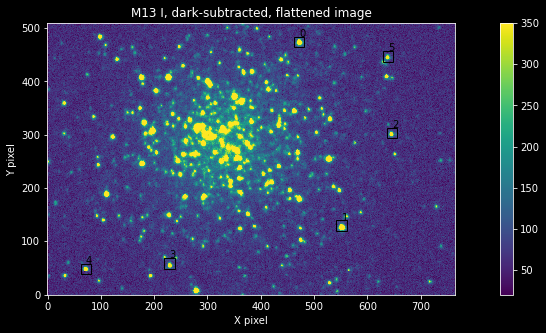

In [13]:
fig = pl.figure(figsize=(16,5))
ax = fig.gca()
im = pl.imshow(M13_darksub_I_flattened, 
               origin='lower', interpolation='none', vmax=350, vmin=20)
pl.colorbar(im)
_=pl.title("M13 I, dark-subtracted, flattened image")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")
for ii,(xcen, ycen) in enumerate(star_centers):
    rect = pl.Rectangle(xy=[xcen-width/2, ycen-height/2],
                            width=width, height=height,
                        facecolor='none', edgecolor='k')
    ax.add_patch(rect)
    ax.text(xcen, ycen+height/2, str(ii), color='k')

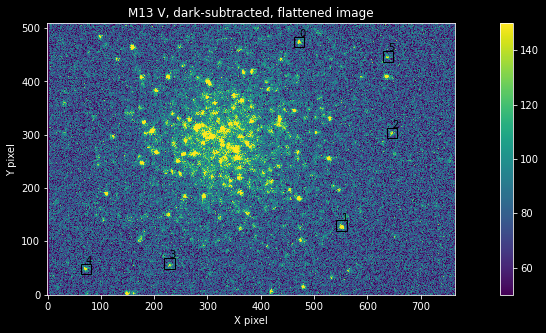

In [14]:
fig = pl.figure(figsize=(16,5))
ax = fig.gca()
im = pl.imshow(M13_darksub_V_flattened, 
               origin='lower', interpolation='none', vmax=150, vmin=50)
pl.colorbar(im)
_=pl.title("M13 V, dark-subtracted, flattened image")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")
for ii,(xcen, ycen) in enumerate(star_centers):
    rect = pl.Rectangle(xy=[xcen-width/2, ycen-height/2],
                            width=width, height=height,
                        facecolor='none', edgecolor='k')
    ax.add_patch(rect)
    ax.text(xcen, ycen+height/2, str(ii), color='k')

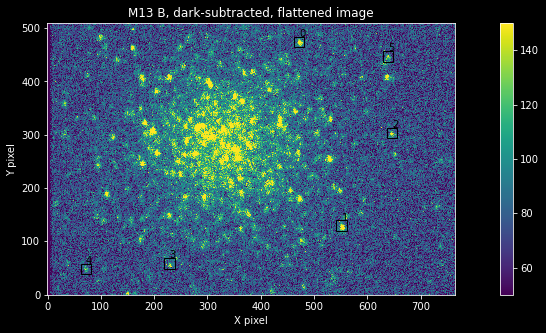

In [15]:
fig = pl.figure(figsize=(16,5))
ax = fig.gca()
im = pl.imshow(M13_darksub_B_flattened, 
               origin='lower', interpolation='none', vmax=150, vmin=50)
pl.colorbar(im)
_=pl.title("M13 B, dark-subtracted, flattened image")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")
for ii,(xcen, ycen) in enumerate(star_centers):
    rect = pl.Rectangle(xy=[xcen-width/2, ycen-height/2],
                            width=width, height=height,
                        facecolor='none', edgecolor='k')
    ax.add_patch(rect)
    ax.text(xcen, ycen+height/2, str(ii), color='k')

In [16]:
for (xc, yc) in star_centers:
    slc = slice(yc-height//2,yc+height//2),slice(xc-width//2,xc+width//2)
    print(slc)

(slice(464, 484, None), slice(462, 482, None))
(slice(119, 139, None), slice(542, 562, None))
(slice(293, 313, None), slice(636, 656, None))
(slice(48, 68, None), slice(219, 239, None))
(slice(38, 58, None), slice(62, 82, None))
(slice(437, 457, None), slice(629, 649, None))


In [17]:
results_I = [calculate_star_flux_and_error(
    sky_subtracted_M13_I[yc-height//2:yc+height//2,
                                  xc-width//2:xc+width//2],
    M13_darksub_I_flattened_uncertainty[yc-height//2:yc+height//2,
                                                 xc-width//2:xc+width//2],
    sky_stddev_I)
           for (xc,yc) in star_centers]

In [18]:
results_V = [calculate_star_flux_and_error(
    sky_subtracted_M13_V[yc-height//2:yc+height//2,
                                  xc-width//2:xc+width//2],
    M13_darksub_V_flattened_uncertainty[yc-height//2:yc+height//2,
                                                 xc-width//2:xc+width//2],
    sky_stddev_V)
           for (xc,yc) in star_centers]

In [19]:
results_B = [calculate_star_flux_and_error(
    sky_subtracted_M13_B[yc-height//2:yc+height//2,
                                  xc-width//2:xc+width//2],
    M13_darksub_B_flattened_uncertainty[yc-height//2:yc+height//2,
                                                 xc-width//2:xc+width//2],
    sky_stddev_B)
           for (xc,yc) in star_centers]

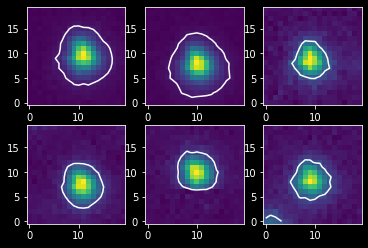

In [20]:
for ii,(xc, yc) in enumerate(star_centers):
    ax = pl.subplot(2,3,ii+1)
    cutout = sky_subtracted_M13_I[yc-height//2:yc+height//2,
                                           xc-width//2:xc+width//2]
    ax.imshow(cutout)
    ax.contour(cutout, levels=[2*sky_stddev_I], colors=['w'])

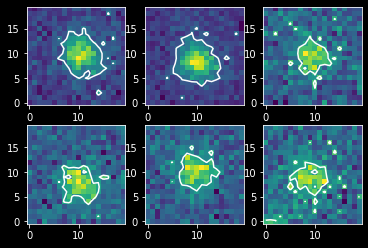

In [21]:
for ii,(xc, yc) in enumerate(star_centers):
    ax = pl.subplot(2,3,ii+1)
    cutout = sky_subtracted_M13_V[yc-height//2:yc+height//2,
                                           xc-width//2:xc+width//2]
    ax.imshow(cutout)
    ax.contour(cutout, levels=[2*sky_stddev_V], colors=['w'])

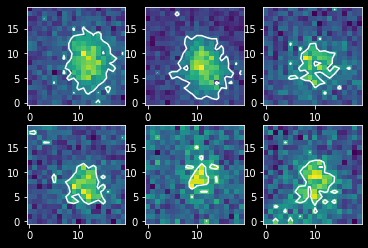

In [22]:
for ii,(xc, yc) in enumerate(star_centers):
    ax = pl.subplot(2,3,ii+1)
    cutout = sky_subtracted_M13_B[yc-height//2:yc+height//2,
                                           xc-width//2:xc+width//2]
    ax.imshow(cutout)
    ax.contour(cutout, levels=[2*sky_stddev_B], colors=['w'])

In [23]:
fluxesI, uncertaintiesI = np.array(results_I).T

Table([np.arange(len(fluxesI)), fluxesI, uncertaintiesI], names=['Star Number', 'Flux', 'Uncertainty'])

<Table length=6>
Star Number        Flux           Uncertainty    
   int32         float64            float64      
----------- ------------------ ------------------
          0   83585.6336977678 1077.6154711562558
          1 115141.37997071948 1172.0945968688343
          2  17630.16883393226  693.7282653900884
          3 30883.263691268075   817.380441804163
          4 31414.537873473426  772.7071746894097
          5 22129.153648122614  780.9368528168974

In [24]:
fluxesV, uncertaintiesV = np.array(results_V).T

Table([np.arange(len(fluxesV)), fluxesV, uncertaintiesV], names=['Star Number', 'Flux', 'Uncertainty'])

<Table length=6>
Star Number        Flux           Uncertainty    
   int32         float64            float64      
----------- ------------------ ------------------
          0  5479.296816836787 236.74300403352441
          1  7056.828539537766 249.34025975757797
          2  2478.286410366641 184.30345031030132
          3 2811.4064082343634 182.40679178732705
          4 2840.6077010228278 181.99476592886555
          5 2802.6181823197635 199.28209870884476

In [25]:
fluxesB, uncertaintiesB = np.array(results_B).T

Table([np.arange(len(fluxesB)), fluxesB, uncertaintiesB], names=['Star Number', 'Flux', 'Uncertainty'])

<Table length=6>
Star Number        Flux           Uncertainty    
   int32         float64            float64      
----------- ------------------ ------------------
          0  7721.577104007786 310.32952065147686
          1 10117.947546128484  332.3846184127641
          2 3273.2008535738305  221.5648302013641
          3 3784.0320706850353 226.24753982649304
          4 1595.9999721181357 158.32324368948903
          5 3272.4088039944613 223.86506879233133

In [26]:
star_coordinates = SkyCoord("""16:41:47.0167578273 +36:25:57.510262514
                               16 41 50.9158342381 +36 28 54.352100797
                               16 41 37.2459903823 +36 29 36.771155671
                               16 41 54.6139410620 +36 27 22.833677631
                               16 41 30.5282006958 +36 29 43.440688187
                               16 41 54.1018816151 +36 26 09.078064195""".split("\n"), frame='fk5', unit=(u.hour, u.deg))
star_coordinates

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    [(250.44590316, 36.43264174), (250.46214931, 36.48176447),
     (250.40519163, 36.49354754), (250.47755809, 36.45634269),
     (250.37720084, 36.49540019), (250.47542451, 36.43585502)]>

According to Simbad,
Star 1: 13.48	12.03
star 2: 13.65	11.91
Star 3: 13.92	12.83
Star 4: 14.27	13.18
Star 5: 13.89	12.70
Star 6: 14.11	12.99

In [27]:
Simbad.reset_votable_fields()
Simbad.add_votable_fields('flux(B)', 'flux(V)', 'flux(I)')

Table([np.arange(len(fluxesV)), fluxesV, uncertaintiesV, star_coordinates.ra, star_coordinates.dec],
      names=['Star Number', 'Flux', 'Uncertainty', 'RA', 'Dec'])

<Table length=6>
Star Number        Flux        ...         RA                Dec        
                               ...        deg                deg        
   int32         float64       ...      float64            float64      
----------- ------------------ ... ------------------ ------------------
          0  5479.296816836787 ...  250.4459031576137  36.43264173958722
          1  7056.828539537766 ...  250.4621493093254 36.481764472443615
          2  2478.286410366641 ... 250.40519162659288 36.493547543241945
          3 2811.4064082343634 ...  250.4775580877583  36.45634268823083
          4 2840.6077010228278 ... 250.37720083623248  36.49540019116306
          5 2802.6181823197635 ... 250.47542450672952  36.43585501783194

In [28]:
simbad_rslt = Simbad.query_region(star_coordinates[0], radius=2*u.arcsec)
simbad_rslt

<Table length=1>
        MAIN_ID               RA           DEC      ...  FLUX_I SCRIPT_NUMBER_ID
                           "h:m:s"       "d:m:s"    ...   mag                   
         object             str13         str13     ... float32      int32      
----------------------- ------------- ------------- ... ------- ----------------
2MASS J16414703+3625576 16 41 47.0167 +36 25 57.510 ...      --                1

In [29]:
viz_result = Vizier.query_region(star_coordinates[1], radius=2*u.arcsec, catalog='J/MNRAS/485/3042')
viz_result

TableList with 1 tables:
	'0:J/MNRAS/485/3042/table4' with 25 column(s) and 3 row(s) 

In [30]:
viz_result[0][1]

<Row index=1>
Cluster  Star    Xpos      Ypos     Umag    e_Umag   o_Umag   Bmag    e_Bmag   o_Bmag   Vmag    e_Vmag   o_Vmag   Rmag    e_Rmag   o_Rmag   Imag    e_Imag   o_Imag   Chi     Sharp      Vary     Weight   RAJ2000     DEJ2000  
                arcsec    arcsec    mag      mag              mag      mag              mag      mag              mag      mag              mag      mag                                                   "h:m:s"     "d:m:s"  
  str7  int32  float64   float64  float32  float32   int16  float32  float32   int16  float32  float32   int16  float32  float32   int16  float32  float32   int16  float32  float64   float64   float32    str11       str11   
------- ----- --------- --------- ------- ---------- ------ ------- ---------- ------ ------- ---------- ------ ------- ---------- ------ ------- ---------- ------ ------- --------- ---------- ------- ----------- -----------
NGC6205 89811   113.494    77.330  15.008     0.0328     27  13.647     0.0307     46  11.972     0.0125     90  11.117     0.0047     37  10.478     0.0199     51   2.207    -0.047      5.950   122.5 16 41 50.91 +36 28 54.3

According to Simbad,
Star 1: 13.48	12.03

In [31]:
mags_star1 = viz_result[0]['Bmag','Vmag','Imag']
mags_star1 = np.delete(mags_star1,(0,2), axis = 0)
mags_star1

array([(13.647, 11.972, 10.478)],
      dtype=[('Bmag', '<f4'), ('Vmag', '<f4'), ('Imag', '<f4')])

In [32]:
mags_for_stars = {}
i = [0,1,0,0,0,0]
for starnum,j in zip((0,1,2,3,4,5),i):
    viz_result = Vizier.query_region(star_coordinates[starnum], radius=2*u.arcsec, catalog='J/MNRAS/485/3042')
    mags_for_stars[starnum] = viz_result[0][j][['Bmag','Vmag','Imag']]

In [33]:
#i = [0,1,0,0,0,0]
#list(zip((0,1,2,3,4,5),i))

In [34]:
mags_for_stars

{0: <Row index=0>
   Bmag    Vmag    Imag 
   mag     mag     mag  
 float32 float32 float32
 ------- ------- -------
  13.546  12.127  10.675,
 1: <Row index=1>
   Bmag    Vmag    Imag 
   mag     mag     mag  
 float32 float32 float32
 ------- ------- -------
  13.647  11.972  10.478,
 2: <Row index=0>
   Bmag    Vmag    Imag 
   mag     mag     mag  
 float32 float32 float32
 ------- ------- -------
  13.982  12.809  11.570,
 3: <Row index=0>
   Bmag    Vmag    Imag 
   mag     mag     mag  
 float32 float32 float32
 ------- ------- -------
  14.265  13.201  12.038,
 4: <Row index=0>
   Bmag    Vmag    Imag 
   mag     mag     mag  
 float32 float32 float32
 ------- ------- -------
  13.874  12.675  11.405,
 5: <Row index=0>
   Bmag    Vmag    Imag 
   mag     mag     mag  
 float32 float32 float32
 ------- ------- -------
  14.121  13.047  11.859}

In [35]:
b_mags = [mags_for_stars[starnum]['Bmag'] for starnum in (0,1,2,3,4,5,)]
v_mags = [mags_for_stars[starnum]['Vmag'] for starnum in (0,1,2,3,4,5,)]
i_mags = [mags_for_stars[starnum]['Imag'] for starnum in (0,1,2,3,4,5,)]
b_mags, v_mags, i_mags

([13.546, 13.647, 13.982, 14.265, 13.874, 14.121],
 [12.127, 11.972, 12.809, 13.201, 12.675, 13.047],
 [10.675, 10.478, 11.57, 12.038, 11.405, 11.859])

In [36]:
#indices = [1, 2, 3, 5]
#a = np.array(fluxesV)
#b = a[indices]
#fluxes_my = list(b)
#
#c = np.array(uncertaintiesV)
#d = c[indices]
#uncertainties_my = list(d)
#
#x = np.array(star_coordinates.ra)
#y = x[indices]
#star_coordinates_ra = list(y)
#
#z = np.array(star_coordinates.dec)
#t = z[indices]
#star_coordinates_dec = list(t)
#
#fluxes_my, uncertainties_my, star_coordinates_ra, star_coordinates_dec

In [37]:
cal_table_I = Table([np.arange(len(fluxesI)), fluxesI*u.electron, uncertaintiesI*u.electron, star_coordinates.ra, star_coordinates.dec,
       v_mags, b_mags, i_mags],
      names=['Star Number', 'Flux', 'Uncertainty', 'RA', 'Dec', 'Vmag', 'Bmag', 'Imag'])
cal_table_I

<Table length=6>
Star Number        Flux           Uncertainty     ...   Vmag    Bmag    Imag 
                 electron           electron      ...                        
   int32         float64            float64       ... float32 float32 float32
----------- ------------------ ------------------ ... ------- ------- -------
          0   83585.6336977678 1077.6154711562558 ...  12.127  13.546  10.675
          1 115141.37997071948 1172.0945968688343 ...  11.972  13.647  10.478
          2  17630.16883393226  693.7282653900884 ...  12.809  13.982   11.57
          3 30883.263691268075   817.380441804163 ...  13.201  14.265  12.038
          4 31414.537873473426  772.7071746894097 ...  12.675  13.874  11.405
          5 22129.153648122614  780.9368528168974 ...  13.047  14.121  11.859

In [38]:
cal_table_V = Table([np.arange(len(fluxesV)), fluxesV*u.electron, uncertaintiesV*u.electron, star_coordinates.ra, star_coordinates.dec,
       v_mags, b_mags, i_mags],
      names=['Star Number', 'Flux', 'Uncertainty', 'RA', 'Dec', 'Vmag', 'Bmag', 'Imag'])
cal_table_V

<Table length=6>
Star Number        Flux           Uncertainty     ...   Vmag    Bmag    Imag 
                 electron           electron      ...                        
   int32         float64            float64       ... float32 float32 float32
----------- ------------------ ------------------ ... ------- ------- -------
          0  5479.296816836787 236.74300403352441 ...  12.127  13.546  10.675
          1  7056.828539537766 249.34025975757797 ...  11.972  13.647  10.478
          2  2478.286410366641 184.30345031030132 ...  12.809  13.982   11.57
          3 2811.4064082343634 182.40679178732705 ...  13.201  14.265  12.038
          4 2840.6077010228278 181.99476592886555 ...  12.675  13.874  11.405
          5 2802.6181823197635 199.28209870884476 ...  13.047  14.121  11.859

In [39]:
cal_table_B = Table([np.arange(len(fluxesB)), fluxesB*u.electron, uncertaintiesB*u.electron, star_coordinates.ra, star_coordinates.dec,
       v_mags, b_mags, i_mags],
      names=['Star Number', 'Flux', 'Uncertainty', 'RA', 'Dec', 'Vmag', 'Bmag', 'Imag'])
cal_table_B

<Table length=6>
Star Number        Flux           Uncertainty     ...   Vmag    Bmag    Imag 
                 electron           electron      ...                        
   int32         float64            float64       ... float32 float32 float32
----------- ------------------ ------------------ ... ------- ------- -------
          0  7721.577104007786 310.32952065147686 ...  12.127  13.546  10.675
          1 10117.947546128484  332.3846184127641 ...  11.972  13.647  10.478
          2 3273.2008535738305  221.5648302013641 ...  12.809  13.982   11.57
          3 3784.0320706850353 226.24753982649304 ...  13.201  14.265  12.038
          4 1595.9999721181357 158.32324368948903 ...  12.675  13.874  11.405
          5 3272.4088039944613 223.86506879233133 ...  13.047  14.121  11.859

In [40]:
bessel_v_mag0 = 3579.76*u.Jy

In [41]:
mag_v_0 = cal_table_V['Vmag'][0]
flux_v_0 = 10**(-mag_v_0/2.5) * bessel_v_mag0
mag_v_0,flux_v_0

(12.127, <Quantity 0.0504724 Jy>)

In [42]:
os.chdir("C:\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 1\\AST3722-Fall-2021-09-29-21")

In [43]:
exptime = fits.getheader('M13_darksub_C1_flattened.FIT')['EXPTIME'] * u.s
exptime

<Quantity 20. s>

In [44]:
star_0_electron_counts = cal_table_V['Flux'].quantity[0]
star_0_countrate = star_0_electron_counts / exptime
star_0_countrate

<Quantity 273.96484084 electron / s>

In [45]:
-2.5*np.log10(star_0_countrate.value), -2.5*np.log10(star_0_electron_counts.value) + 2.5*np.log10(exptime.value)

star_0_instrumental_mag = -2.5*np.log10(star_0_countrate.value)
zeropoint = mag_v_0 - star_0_instrumental_mag 
star_0_instrumental_mag, zeropoint

(-6.094237078509607, 18.22123693355111)

In [46]:
zeropoint_measurements_V = []
for row in cal_table_V:
    mag_v = row['Vmag']
    if mag_v:
        star_countrate = row['Flux'] / exptime
        star_instrumental_mag = -2.5*np.log10(star_countrate.value)
        zeropoint = mag_v - star_instrumental_mag 
        print(f"Instrumental magnitude V of star {row['Star Number']}={star_instrumental_mag:0.1f}, m_zp={zeropoint:0.1f}")
        zeropoint_measurements_V.append(zeropoint)

zeropoint_measurements_I = []
for row in cal_table_I:
    mag_I = row['Imag']
    if mag_I:
        star_countrate = row['Flux'] / exptime
        star_instrumental_mag = -2.5*np.log10(star_countrate.value)
        zeropoint = mag_I - star_instrumental_mag 
        print(f"Instrumental magnitude I of star {row['Star Number']}={star_instrumental_mag:0.1f}, m_zp={zeropoint:0.1f}")
        zeropoint_measurements_I.append(zeropoint)

zeropoint_measurements_B = []
for row in cal_table_B:
    mag_B = row['Bmag']
    if mag_B:
        star_countrate = row['Flux'] / exptime
        star_instrumental_mag = -2.5*np.log10(star_countrate.value)
        zeropoint = mag_B - star_instrumental_mag 
        print(f"Instrumental magnitude B of star {row['Star Number']}={star_instrumental_mag:0.1f}, m_zp={zeropoint:0.1f}")
        zeropoint_measurements_B.append(zeropoint)

Instrumental magnitude V of star 0=-6.1, m_zp=18.2
Instrumental magnitude V of star 1=-6.4, m_zp=18.3
Instrumental magnitude V of star 2=-5.2, m_zp=18.0
Instrumental magnitude V of star 3=-5.4, m_zp=18.6
Instrumental magnitude V of star 4=-5.4, m_zp=18.1
Instrumental magnitude V of star 5=-5.4, m_zp=18.4
Instrumental magnitude I of star 0=-9.1, m_zp=19.7
Instrumental magnitude I of star 1=-9.4, m_zp=19.9
Instrumental magnitude I of star 2=-7.4, m_zp=18.9
Instrumental magnitude I of star 3=-8.0, m_zp=20.0
Instrumental magnitude I of star 4=-8.0, m_zp=19.4
Instrumental magnitude I of star 5=-7.6, m_zp=19.5
Instrumental magnitude B of star 0=-6.5, m_zp=20.0
Instrumental magnitude B of star 1=-6.8, m_zp=20.4
Instrumental magnitude B of star 2=-5.5, m_zp=19.5
Instrumental magnitude B of star 3=-5.7, m_zp=20.0
Instrumental magnitude B of star 4=-4.8, m_zp=18.6
Instrumental magnitude B of star 5=-5.5, m_zp=19.7


In [47]:
mag_sky_inst_V = -2.5 * np.log10(sky_mean_V / exptime.value)
mag_sky_inst_B = -2.5 * np.log10(sky_mean_B / exptime.value)
mag_sky_inst_I = -2.5 * np.log10(sky_mean_I / exptime.value)
mag_sky_inst_V, mag_sky_inst_B, mag_sky_inst_I

(-1.4291234739400833, -1.383622728910027, -1.2407784088087601)

In [48]:
avg_zpV, std_zpV = np.mean(zeropoint_measurements_V),np.std(zeropoint_measurements_V)
print(f"Zero-point V is estimated to be {avg_zpV:0.1f}+/-{std_zpV:0.1f}")
avg_zpI, std_zpI = np.mean(zeropoint_measurements_I),np.std(zeropoint_measurements_I)
print(f"Zero-point I is estimated to be {avg_zpI:0.1f}+/-{std_zpI:0.1f}")
avg_zpB, std_zpB = np.mean(zeropoint_measurements_B),np.std(zeropoint_measurements_B)
print(f"Zero-point B is estimated to be {avg_zpB:0.1f}+/-{std_zpB:0.1f}")

Zero-point V is estimated to be 18.3+/-0.2
Zero-point I is estimated to be 19.6+/-0.4
Zero-point B is estimated to be 19.7+/-0.6


In [49]:
mag_sky_V = mag_sky_inst_V + avg_zpV
mag_sky_I = mag_sky_inst_I + avg_zpI
mag_sky_B = mag_sky_inst_B + avg_zpB
print(f"Sky magnitude V is {mag_sky_V:0.2f} per pixel")
print(f"Sky magnitude I is {mag_sky_I:0.2f} per pixel")
print(f"Sky magnitude B is {mag_sky_B:0.2f} per pixel")

pixscale = 0.55*u.arcsec

sky_brightness_V = mag_sky_V + 2.5*np.log10(pixscale**2 / u.arcsec**2)
sky_brightness_I = mag_sky_I + 2.5*np.log10(pixscale**2 / u.arcsec**2)
sky_brightness_B = mag_sky_B + 2.5*np.log10(pixscale**2 / u.arcsec**2)

print(f"The sky surface brightness in V is {sky_brightness_V:0.2f} magnitudes per square arcsecond")
print(f"The sky surface brightness in I is {sky_brightness_I:0.2f} magnitudes per square arcsecond")
print(f"The sky surface brightness in B is {sky_brightness_B:0.2f} magnitudes per square arcsecond")

Sky magnitude V is 16.84 per pixel
Sky magnitude I is 18.33 per pixel
Sky magnitude B is 18.31 per pixel
The sky surface brightness in V is 15.55 magnitudes per square arcsecond
The sky surface brightness in I is 17.03 magnitudes per square arcsecond
The sky surface brightness in B is 17.01 magnitudes per square arcsecond


In [134]:
sky_brightness_V_std = np.std(sky_brightness_V)
sky_brightness_I_std = np.std(sky_brightness_I)
sky_brightness_B_std = np.std(sky_brightness_B)
sky_brightness_V_std,sky_brightness_I_std,sky_brightness_B_std

(<Quantity 0.>, <Quantity 0.>, <Quantity 0.>)

Sky mean is in counts per pixle for 

## Background

In [50]:
background_I = np.median(M13_darksub_I_flattened)
background_V = np.median(M13_darksub_V_flattened)
background_B = np.median(M13_darksub_B_flattened)

## Centroiding 

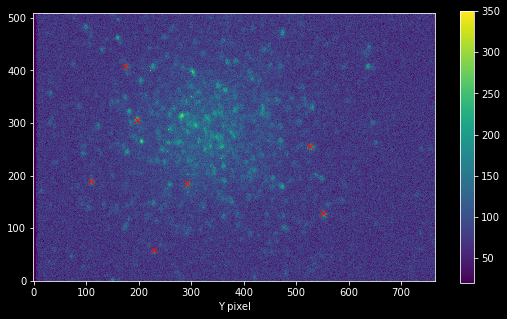

In [51]:
# show where the selected star is
_=pl.figure(figsize=(9,5))
_=pl.imshow(M13_darksub_B_flattened, 
               origin='lower', interpolation='none', vmax=350, vmin=20)
##_=pl.plot(472,474,'rx') ##1
_=pl.plot(197,306,'rx') ## new 1 for B
_=pl.plot(552,129,'rx')
_=pl.plot(175,409,'rx')
_=pl.plot(229,58,'rx')
_=pl.plot(292,185,'rx') ## new 4 for B
_=pl.plot(110,190,'rx')
_=pl.plot(527,257,'rx')
_=pl.colorbar()
_=pl.xlabel("X pixel")
_=pl.xlabel("Y pixel")

### V

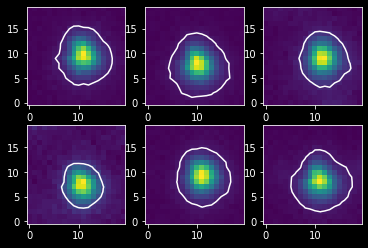

In [52]:
star_centers = [[472,474],[552,129],[175,409],[229,58],[110,190],[527,257]]
for ii,(xc, yc) in enumerate(star_centers):
    ax = pl.subplot(2,3,ii+1)
    cutout = sky_subtracted_M13_I[yc-height//2:yc+height//2,
                                           xc-width//2:xc+width//2]
    ax.imshow(cutout)
    ax.contour(cutout, levels=[2*sky_stddev_I], colors=['w'])

In [53]:
##star_cutout1 = sky_subtracted_M13_B[464:484,462:482]
472,474
star_cutout1 = sky_subtracted_M13_B[296:316,187:207] ## 197,306
star_cutout2 = sky_subtracted_M13_B[119:139,542:562]
star_cutout3 = sky_subtracted_M13_B[399:419,165:185] 
star_cutout4 = sky_subtracted_M13_B[175:195,282:302] ##292,185
star_cutout5 = sky_subtracted_M13_B[180:200,100:120]
star_cutout6 = sky_subtracted_M13_B[247:267,517:537] 

In [54]:
yc1, xc1 = np.indices(star_cutout1.shape)
mom1_x1 = (xc1 * star_cutout1).sum() / star_cutout1.sum()
mom1_y1 = (yc1 * star_cutout1).sum() / star_cutout1.sum()
print("Moments for Star 1:",mom1_x1, mom1_y1)

yc2, xc2 = np.indices(star_cutout2.shape)
mom1_x2 = (xc2 * star_cutout2).sum() / star_cutout2.sum()
mom1_y2 = (yc2 * star_cutout2).sum() / star_cutout2.sum()
print("Moments for Star 2:",mom1_x2, mom1_y2)

yc3, xc3 = np.indices(star_cutout3.shape)
mom1_x3 = (xc3 * star_cutout3).sum() / star_cutout3.sum()
mom1_y3 = (yc3 * star_cutout3).sum() / star_cutout3.sum()
print("Moments for Star 3:",mom1_x3, mom1_y3)

yc4, xc4 = np.indices(star_cutout4.shape)
mom1_x4 = (xc4 * star_cutout4).sum() / star_cutout4.sum()
mom1_y4 = (yc4 * star_cutout4).sum() / star_cutout4.sum()
print("Moments for Star 4:",mom1_x4, mom1_y4)

yc5, xc5 = np.indices(star_cutout5.shape)
mom1_x5 = (xc5 * star_cutout5).sum() / star_cutout5.sum()
mom1_y5 = (yc5 * star_cutout5).sum() / star_cutout5.sum()
print("Moments for Star 5:",mom1_x5, mom1_y5)

yc6, xc6 = np.indices(star_cutout6.shape)
mom1_x6 = (xc6 * star_cutout6).sum() / star_cutout6.sum()
mom1_y6 = (yc6 * star_cutout6).sum() / star_cutout6.sum()
print("Moments for Star 6:",mom1_x6, mom1_y6)

Moments for Star 1: 9.869254549886154 9.623188309297113
Moments for Star 2: 10.721698230375832 7.769995605098309
Moments for Star 3: 11.407170222305384 9.05243334632002
Moments for Star 4: 10.973023789736322 8.880410339766238
Moments for Star 5: 10.809667222972195 8.73764104135387
Moments for Star 6: 10.680202978177933 8.04529943238677


In [55]:
proj_x1 = star_cutout1.sum(axis=0) # projection along the y-axis, onto the x-axis
proj_y1 = star_cutout1.sum(axis=1) # projection along the x-axis, onto the y-axis
proj_x2 = star_cutout2.sum(axis=0) 
proj_y2 = star_cutout2.sum(axis=1) 
proj_x3 = star_cutout3.sum(axis=0) 
proj_y3 = star_cutout3.sum(axis=1) 
proj_x4 = star_cutout4.sum(axis=0) 
proj_y4 = star_cutout4.sum(axis=1) 
proj_x5 = star_cutout5.sum(axis=0) 
proj_y5 = star_cutout5.sum(axis=1) 
proj_x6 = star_cutout6.sum(axis=0) 
proj_y6 = star_cutout6.sum(axis=1) 

### Width measurement 

In [56]:
mom2_x1 = ((xc1 - mom1_x1)**2 * star_cutout1).sum() / star_cutout1.sum()
mom2_y1 = ((yc1 - mom1_y1)**2 * star_cutout1).sum() / star_cutout1.sum()
print("Star1:", mom2_x1, mom2_y1, "pixels^2") # units: pixels^2

mom2_x2 = ((xc2 - mom1_x2)**2 * star_cutout2).sum() / star_cutout2.sum()
mom2_y2 = ((yc2 - mom1_y2)**2 * star_cutout2).sum() / star_cutout2.sum()
print("Star2:", mom2_x2, mom2_y2,"pixels^2")

mom2_x3 = ((xc3 - mom1_x3)**2 * star_cutout3).sum() / star_cutout3.sum()
mom2_y3 = ((yc3 - mom1_y3)**2 * star_cutout3).sum() / star_cutout3.sum()
print("Star3:", mom2_x3, mom2_y3,"pixels^2") 

mom2_x4 = ((xc4 - mom1_x4)**2 * star_cutout4).sum() / star_cutout4.sum()
mom2_y4 = ((yc4 - mom1_y4)**2 * star_cutout4).sum() / star_cutout4.sum()
print("Star4:", mom2_x4, mom2_y4,"pixels^2") 

mom2_x5 = ((xc5 - mom1_x5)**2 * star_cutout5).sum() / star_cutout5.sum()
mom2_y5 = ((yc5 - mom1_y5)**2 * star_cutout5).sum() / star_cutout5.sum()
print("Star5:", mom2_x5, mom2_y5,"pixels^2") 

mom2_x6 = ((xc6 - mom1_x6)**2 * star_cutout6).sum() / star_cutout6.sum()
mom2_y6 = ((yc6 - mom1_y6)**2 * star_cutout6).sum() / star_cutout6.sum()
print("Star6:", mom2_x6, mom2_y6,"pixels^2") 

Star1: 22.99626165379962 23.223929969116128 pixels^2
Star2: 16.723058855344117 18.414460864371414 pixels^2
Star3: 21.140462222293703 25.663609067139646 pixels^2
Star4: 24.52210715810021 25.680931180003817 pixels^2
Star5: 19.043372563628832 19.33104546866644 pixels^2
Star6: 22.712068669359752 19.197339431657998 pixels^2


In [57]:
# convert "moment 2" to "sigma" first:
sigma_x1, sigma_y1 = mom2_x1**0.5, mom2_y1**0.5
sigma_x2, sigma_y2 = mom2_x2**0.5, mom2_y2**0.5
sigma_x3, sigma_y3 = mom2_x3**0.5, mom2_y3**0.5
sigma_x4, sigma_y4 = mom2_x4**0.5, mom2_y4**0.5
sigma_x5, sigma_y5 = mom2_x5**0.5, mom2_y5**0.5
sigma_x6, sigma_y6 = mom2_x6**0.5, mom2_y6**0.5

In [58]:
sigma_to_fwhm = np.sqrt(8*np.log(2))
sigma_to_fwhm

2.3548200450309493

In [59]:
fwhm_x1, fwhm_y1 = sigma_x1*sigma_to_fwhm, sigma_y1*sigma_to_fwhm
print(sigma_x1, sigma_y1)
print(fwhm_x1, fwhm_y1)

fwhm_x2, fwhm_y2 = sigma_x2*sigma_to_fwhm, sigma_y2*sigma_to_fwhm
print(sigma_x2, sigma_y2)
print(fwhm_x2, fwhm_y2)

fwhm_x3, fwhm_y3 = sigma_x3*sigma_to_fwhm, sigma_y3*sigma_to_fwhm
print(sigma_x3, sigma_y3)
print(fwhm_x3, fwhm_y3)

fwhm_x4, fwhm_y4 = sigma_x4*sigma_to_fwhm, sigma_y4*sigma_to_fwhm
print(sigma_x4, sigma_y4)
print(fwhm_x4, fwhm_y4)

fwhm_x5, fwhm_y5 = sigma_x5*sigma_to_fwhm, sigma_y5*sigma_to_fwhm
print(sigma_x5, sigma_y5)
print(fwhm_x5, fwhm_y5)

fwhm_x6, fwhm_y6 = sigma_x6*sigma_to_fwhm, sigma_y6*sigma_to_fwhm
print(sigma_x6, sigma_y6)
print(fwhm_x6, fwhm_y6)

4.795441757940515 4.81912128599355
11.292402376376778 11.348163403692936
4.089383676710234 4.29120739004437
9.629762653739624 10.105021179461426
4.597875838068456 5.065926279283942
10.827170188047075 11.929344749106882
4.951980124970233 5.067635659753354
11.661022060874771 11.933370032500838
4.363871281743863 4.396708481201186
10.27613156818535 10.353457263690133
4.765718064401183 4.381476855086421
11.222408427018001 10.317589525196668


In [60]:
fwhm_x1 = mom2_x4**0.5*sigma_to_fwhm
fwhm_y1 = mom2_y4**0.5*sigma_to_fwhm
fwhm_x2 = mom2_x2**0.5*sigma_to_fwhm
fwhm_y2 = mom2_y2**0.5*sigma_to_fwhm
fwhm_x3 = mom2_x3**0.5*sigma_to_fwhm
fwhm_y3 = mom2_y3**0.5*sigma_to_fwhm
fwhm_x4 = mom2_x4**0.5*sigma_to_fwhm
fwhm_y4 = mom2_y4**0.5*sigma_to_fwhm
fwhm_x5 = mom2_x5**0.5*sigma_to_fwhm
fwhm_y5 = mom2_y5**0.5*sigma_to_fwhm
fwhm_x6 = mom2_x6**0.5*sigma_to_fwhm
fwhm_y6 = mom2_y6**0.5*sigma_to_fwhm

In [61]:
fwhm_measurements = [(fwhm_x1, fwhm_y1),
 (fwhm_x2, fwhm_y2),
 (fwhm_x3, fwhm_y3),
 (fwhm_x4, fwhm_y4),
 (fwhm_x5, fwhm_y5),
 (fwhm_x6, fwhm_y6)
]*u.pix*pixscale
fwhm_measurements

<Quantity [[6.41356213, 6.56335352],
           [5.29636946, 5.55776165],
           [5.9549436 , 6.56113961],
           [6.41356213, 6.56335352],
           [5.65187236, 5.6944015 ],
           [6.17232463, 5.67467424]] arcsec pix>

In [62]:
def fwhm_calculation(star_cutout):
    sigma_to_fwhm = np.sqrt(8*np.log(2))
    yc, xc = np.indices(star_cutout.shape)
    mom1_x = (xc * star_cutout).sum() / star_cutout.sum()
    mom1_y = (yc * star_cutout).sum() / star_cutout.sum()
    mom2_x = ((xc - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
    mom2_y = ((yc - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
    fwhm_x = mom2_x**0.5*sigma_to_fwhm
    fwhm_y = mom2_y**0.5*sigma_to_fwhm
    avg_fwhm = (fwhm_x*fwhm_y)**0.5 
    pixscale = 0.6*u.arcsec/u.pixel
    fwhm_x_arcsec = fwhm_x*u.pixel * pixscale
    fwhm_y_arcsec = fwhm_y*u.pixel * pixscale
    spatialres = (fwhm_x_arcsec*fwhm_y_arcsec)**0.5 /u.arcsec
    print(f"FWHM average, in pixels: {avg_fwhm}")
    return avg_fwhm, spatialres

In [63]:
star_cutout1I = sky_subtracted_M13_I[464:484,462:482]
star_cutout2I = sky_subtracted_M13_I[119:139,542:562]
star_cutout3I = sky_subtracted_M13_I[399:419,165:185] 
star_cutout4I = sky_subtracted_M13_I[48:68,219:239] 
star_cutout5I = sky_subtracted_M13_I[180:200,100:120]
star_cutout6I = sky_subtracted_M13_I[247:267,517:537] 

In [64]:
#star_cutout1B = sky_subtracted_M13_B[464:484,462:482]  ## for swapped
#star_cutout2B = sky_subtracted_M13_B[119:139,542:562]
#star_cutout3B = sky_subtracted_M13_B[399:419,165:185] 
#star_cutout4B = sky_subtracted_M13_B[48:68,219:239] 
#star_cutout5B = sky_subtracted_M13_B[180:200,100:120]
#star_cutout6B = sky_subtracted_M13_B[247:267,517:537] 

In [65]:
star_cutout1V = sky_subtracted_M13_V[464:484,462:482]
star_cutout2V = sky_subtracted_M13_V[119:139,542:562]
star_cutout3V = sky_subtracted_M13_V[399:419,165:185] 
star_cutout4V = sky_subtracted_M13_V[48:68,219:239] 
star_cutout5V = sky_subtracted_M13_V[180:200,100:120]
star_cutout6V = sky_subtracted_M13_V[247:267,517:537] 

In [66]:
star_cutout1B = sky_subtracted_M13_B[296:316,187:207]
star_cutout2B = sky_subtracted_M13_B[119:139,542:562]
star_cutout3B = sky_subtracted_M13_B[399:419,165:185] 
star_cutout4B = sky_subtracted_M13_B[175:195,282:302]
star_cutout5B = sky_subtracted_M13_B[180:200,100:120]
star_cutout6B = sky_subtracted_M13_B[247:267,517:537] 

In [67]:
#star_cutout1V = sky_subtracted_M13_V[296:316,187:207] ## for swapped
#star_cutout2V = sky_subtracted_M13_V[119:139,542:562]
#star_cutout3V = sky_subtracted_M13_V[399:419,165:185] 
#star_cutout4V = sky_subtracted_M13_V[175:195,282:302]
#star_cutout5V = sky_subtracted_M13_V[180:200,100:120]
#star_cutout6V = sky_subtracted_M13_V[247:267,517:537] 

In [68]:
fwhm_V1, spatialres_V1 = fwhm_calculation(star_cutout1V)
fwhm_V2, spatialres_V2 = fwhm_calculation(star_cutout2V)
fwhm_V3, spatialres_V3 = fwhm_calculation(star_cutout3V)
fwhm_V4, spatialres_V4 = fwhm_calculation(star_cutout4V)
fwhm_V5, spatialres_V5 = fwhm_calculation(star_cutout5V)
fwhm_V6, spatialres_V6 = fwhm_calculation(star_cutout6V)

FWHM average, in pixels: 7.749495994866709
FWHM average, in pixels: 7.94113337181638
FWHM average, in pixels: 10.106172909021485
FWHM average, in pixels: 8.65518985706541
FWHM average, in pixels: 8.571088262479812
FWHM average, in pixels: 9.482418341153346


In [69]:
fwhm_I1, spatialres_I1 = fwhm_calculation(star_cutout1I)
fwhm_I2, spatialres_I2 = fwhm_calculation(star_cutout2I)
fwhm_I3, spatialres_I3 = fwhm_calculation(star_cutout3I)
fwhm_I4, spatialres_I4 = fwhm_calculation(star_cutout4I)
fwhm_I5, spatialres_I5 = fwhm_calculation(star_cutout5I)
fwhm_I6, spatialres_I6 = fwhm_calculation(star_cutout6I)

FWHM average, in pixels: 7.255447008411929
FWHM average, in pixels: 6.999639720297222
FWHM average, in pixels: 8.071885931171863
FWHM average, in pixels: 8.29088879798599
FWHM average, in pixels: 7.213663830633632
FWHM average, in pixels: 7.947945848242802


In [70]:
fwhm_B1, spatialres_B1 = fwhm_calculation(star_cutout1B)
fwhm_B2, spatialres_B2 = fwhm_calculation(star_cutout2B)
fwhm_B3, spatialres_B3 = fwhm_calculation(star_cutout3B)
fwhm_B4, spatialres_B4 = fwhm_calculation(star_cutout4B)
fwhm_B5, spatialres_B5 = fwhm_calculation(star_cutout5B)
fwhm_B6, spatialres_B6 = fwhm_calculation(star_cutout6B)

FWHM average, in pixels: 11.32024855678417
FWHM average, in pixels: 9.864530174784077
FWHM average, in pixels: 11.36490412764076
FWHM average, in pixels: 11.796410098397486
FWHM average, in pixels: 10.314721955887327
FWHM average, in pixels: 10.760492722644244


In [71]:
spatialresI = np.array([spatialres_I1, spatialres_I2, spatialres_I3,spatialres_I4,spatialres_I5,spatialres_I6])
spatialresI.std()

0.2943575914013738

In [72]:
fwhmI = np.array([fwhm_I1, fwhm_I2, fwhm_I3,fwhm_I4,fwhm_I5,fwhm_I6])
fwhmI.std()

0.4905959856689564

In [73]:
spatialresV = np.array([spatialres_V1, spatialres_V2, spatialres_V3,spatialres_V4,spatialres_V5,spatialres_V6])
spatialresV.std()

0.49428180661080057

In [74]:
fwhmV = np.array([fwhm_V1, fwhm_V2, fwhm_V3,fwhm_V4,fwhm_V5,fwhm_V6])
fwhmV.std()

0.8238030110180006

In [75]:
spatialB = np.array([spatialres_B1, spatialres_B2, spatialres_B3,spatialres_B4,spatialres_B5,spatialres_B6])
spatialB.std()

0.39727299336457905

In [76]:
fwhmB = np.array([fwhm_B1, fwhm_B2, fwhm_B3,fwhm_B4,fwhm_B5,fwhm_B6])
fwhmB.std()

0.662121655607632

## Airmass

In [77]:
## airmass doesn't change w/ filter but does change w/ time 

https://www.ftexploring.com/solar-energy/air-mass-and-insolation2.htm#trig
airmass = 1/cos(zenith angle)

I1
Local time:9/29/2021 at 22:03:40.000
297°56'44.9"   +28°28'31.9"

I2
'Local time:9/29/2021 at 22:04:01.000'
295°58'22.8"   +34°29'32.6"

I3
Local time:9/29/2021 at 22:04:22.000
295°59'36.6"   +34°25'26.1"

I4
'Local time:9/29/2021 at 22:05:38.000' 
296°04'04.8"   +34°10'34.5"

I5
'Local time:9/29/2021 at 22:05:05.000'
296°02'08.0"   +34°17'01.9"

In [78]:
airmassI = 1/np.cos((28+28/60)*(np.pi/180))

V1
Local time:9/29/2021 at 22:05:38.000
296°00'23.3"   +34°22'44.1"

V2
'Local time:9/29/2021 at 22:05:59.000'
296°05'19.1"   +34°06'28.7"

V3
'Local time:9/29/2021 at 22:07:40.000' 
296°11'19.3"   +33°46'44.9"

V4
'Local time:9/29/2021 at 22:06:20.000'  
296°06'33.6"   +34°02'22.9"

V5
'Local time:9/29/2021 at 22:07:40.000' 
296°11'19.2"   +33°46'45.4"

B1
Local time:9/29/2021 at 22:07:40.000
296°07'44.3"   +33°58'23.0"

B2
'Local time:9/29/2021 at 22:08:01.000'
296°12'34.5"   +33°42'39.4"

B3
'Local time:9/29/2021 at 22:08:22.000'
296°13'49.9"   +33°38'33.5"

B4
'Local time:9/29/2021 at 22:08:44.000' 
296°15'09.1"   +33°34'16.0"

B5
'Local time:9/29/2021 at 22:09:05.000'  
296°16'24.9"   +33°30'10.2"

In [79]:
zeropoint_measurements_V

[18.22123693355111,
 18.34094904657603,
 18.0418037647078,
 18.570734300502117,
 18.055953351840444,
 18.41333478022005]

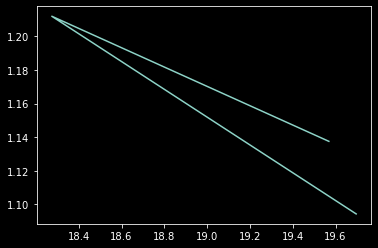

In [80]:
airmassI = 1/np.cos((28+28/60)*(np.pi/180))
airmassV = 1/np.cos((34+24/60)*(np.pi/180))
airmassB = 1/np.cos((23+58/60)*(np.pi/180))
airmass = [airmassI,airmassV,airmassB]
zeropoint = [avg_zpI,avg_zpV,avg_zpB]

plt.plot(zeropoint,airmass)

no observed relationship between airmass and photometric zerro point 

plot skybrightness vs airmass 
skybrightness vs azimuthal angle 

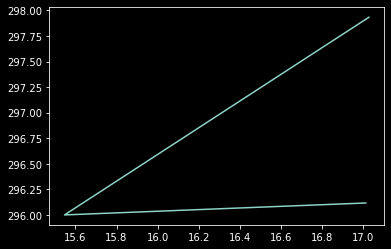

In [81]:
skybrightness = [sky_brightness_I,sky_brightness_V,sky_brightness_B]
azang = [(297+56/60),(296),(296+7/60)]
##uncertainty from zeropoint

plt.plot(skybrightness,azang)

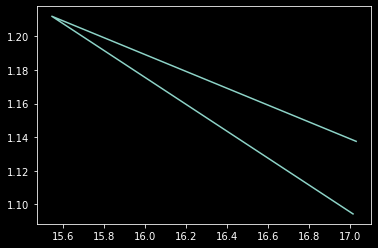

In [82]:
plt.plot(skybrightness,airmass)

## HR Diagram


In [83]:
%matplotlib inline
import numpy as np
import pylab as pl
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['image.interpolation'] = 'none'
from astropy.io import fits
from astropy import stats
from scipy import ndimage
from astropy.table import Table, Column
from astropy import table
pl.style.use('dark_background')
from astropy.stats import mad_std
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry, CircularAperture

In [84]:
os.chdir("C:\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 1\\AST3722-Fall-2021-09-29-21")

In [85]:
M13_darksub_V_flattened = fits.getdata('M13\\darksub_flattened_M13_B.FIT') ## swapped
M13_darksub_V_flattened_uncertainty = fits.getdata('M13_20s_B001_darksub_flattened_uncertainty.fits')

#M13_darksub_V_flattened = fits.getdata('M13\\darksub_flattened_M13_V.FIT')
#M13_darksub_V_flattened_uncertainty = fits.getdata('M13_20s_V001_darksub_flattened_uncertainty.fits')
#
#M13_darksub_B_flattened = fits.getdata('M13\\darksub_flattened_M13_B.FIT')
#M13_darksub_B_flattened_uncertainty = fits.getdata('M13_20s_B001_darksub_flattened_uncertainty.fits')
#
M13_darksub_I_flattened = fits.getdata('M13\\darksub_flattened_M13_I.FIT')
M13_darksub_I_flattened_uncertainty = fits.getdata('M13_20s_I003_darksub_flattened_uncertainty.fits')

M13_darksub_B_flattened = fits.getdata('M13\\darksub_flattened_M13_V.FIT') ## swapped 
M13_darksub_B_flattened_uncertainty = fits.getdata('M13_20s_V001_darksub_flattened_uncertainty.fits')

In [86]:
background_stddev = np.median(M13_darksub_V_flattened_uncertainty)
background_stddev

17.27532422895215

In [87]:
avg_fwhm = fwhm_V3

In [88]:
daofind = DAOStarFinder(fwhm=avg_fwhm, threshold=2.1*background_stddev)  
sources_V = daofind(sky_subtracted_M13_V)

In [89]:
sources_V

<Table length=480>
  id      xcentroid      ...        flux                 mag         
int32      float64       ...      float64              float64       
----- ------------------ ... ------------------ ---------------------
    1   92.2717243108516 ... 1.3213264950436274   -0.3025253587143182
    2 149.58758627052256 ... 10.410011564354738    -2.543628029908103
    3 292.13480479903023 ... 1.6442712877890464   -0.5399336830554166
    4 420.05839991320664 ... 7.9498411587286375   -2.2508961283780278
    5 352.81238705140515 ...  1.672376122207377   -0.5583348954206409
    6  647.5387236664527 ... 1.0406895478976175 -0.043302981933315006
    7  756.2423495968503 ... 1.0424395006074887  -0.04512714876736292
    8 479.94291754659145 ...  6.651881027326796    -2.057361182533191
    9  668.9534157564451 ... 1.2390694663537793  -0.23273913762786116
   10   565.142991034148 ... 1.0221266046389628 -0.023761731401566958
  ...                ... ...                ...                   ...
  471  562.6747454129965 ... 1.1878554654559597  -0.18690900065833077
  472 461.89567364571013 ... 1.1262693767137335  -0.12910568949601714
  473   651.493439974115 ...  1.030182186975437  -0.03228509040683743
  474 452.84744323012615 ...  2.087110417267889    -0.798863564376202
  475  484.3902332767347 ...  1.851972974520322   -0.6690866120441454
  476  392.7191433946665 ...  4.055072894870266   -1.5199966639729738
  477 225.24304147339615 ...  1.310367132085524   -0.2934824778813099
  478  665.4362547624455 ... 1.4752701861520225  -0.42217891452984796
  479 131.35366060776136 ... 1.1749906837770079   -0.1750860580081591
  480 215.54694194484887 ... 1.4532056007161251   -0.4058176574582173

In [90]:
positions = np.transpose((sources_V['xcentroid'], sources_V['ycentroid']))  
apertures_V = CircularAperture(positions, r=avg_fwhm)  
phot_table_V = aperture_photometry(sky_subtracted_M13_V, apertures_V, error=M13_darksub_V_flattened_uncertainty)  
for col in phot_table_V.colnames:  
    phot_table_V[col].info.format = '%.3g'  # "%.3g" will print only 3 values, so it can be used for sig-fig display
phot_table_V

<QTable length=480>
  id  xcenter ycenter aperture_sum aperture_sum_err
        pix     pix                                
int32 float64 float64   float64        float64     
----- ------- ------- ------------ ----------------
    1    92.3    1.64        -50.8              239
    2     150    2.54     5.28e+03              260
    3     292    6.16     1.24e+03              286
    4     420    6.67     4.65e+03              299
    5     353    10.3     1.27e+03              306
    6     648    9.79          122              307
    7     756    12.4         -112              301
    8     480    15.1     4.48e+03              315
    9     669    16.7         -541              308
  ...     ...     ...          ...              ...
  471     563     494          161              308
  472     462     499     1.63e+03              309
  473     651     499         -118              309
  474     453     498     2.19e+03              310
  475     484     500     1.67e+03              310
  476     393     499     2.62e+03              310
  477     225     502          425              290
  478     665     502          254              296
  479     131     504          197              279
  480     216     506          391              251

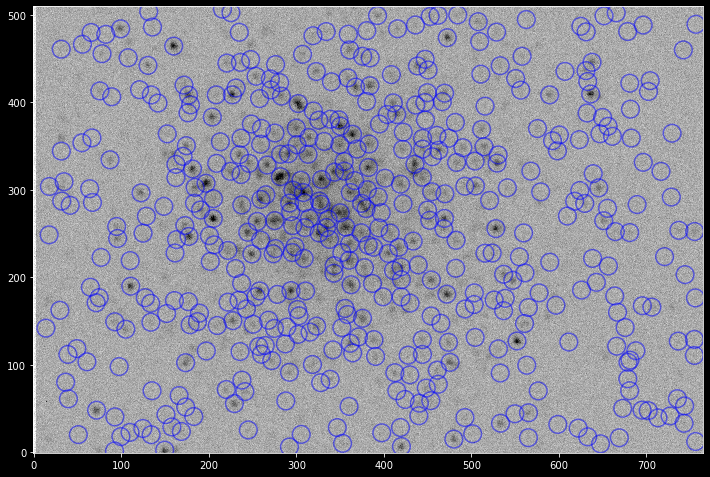

In [91]:
pl.figure(figsize=(12,12))
pl.imshow(sky_subtracted_M13_V, cmap='gray_r', origin='lower', vmax=200, vmin=-100)
_=apertures_V.plot(color='blue', lw=1.5, alpha=0.5)

In [92]:
# rename the phot_tbl columns to indicate they're V-band
for colname in phot_table_V.colnames:
    phot_table_V.rename_column(colname, "V_"+colname)
mtbl_V = table.hstack([sources_V, phot_table_V])
mtbl_V

<QTable length=480>
  id      xcentroid      ... V_aperture_sum V_aperture_sum_err
                         ...                                  
int32      float64       ...    float64          float64      
----- ------------------ ... -------------- ------------------
    1   92.2717243108516 ...          -50.8                239
    2 149.58758627052256 ...       5.28e+03                260
    3 292.13480479903023 ...       1.24e+03                286
    4 420.05839991320664 ...       4.65e+03                299
    5 352.81238705140515 ...       1.27e+03                306
    6  647.5387236664527 ...            122                307
    7  756.2423495968503 ...           -112                301
    8 479.94291754659145 ...       4.48e+03                315
    9  668.9534157564451 ...           -541                308
  ...                ... ...            ...                ...
  471  562.6747454129965 ...            161                308
  472 461.89567364571013 ...       1.63e+03                309
  473   651.493439974115 ...           -118                309
  474 452.84744323012615 ...       2.19e+03                310
  475  484.3902332767347 ...       1.67e+03                310
  476  392.7191433946665 ...       2.62e+03                310
  477 225.24304147339615 ...            425                290
  478  665.4362547624455 ...            254                296
  479 131.35366060776136 ...            197                279
  480 215.54694194484887 ...            391                251

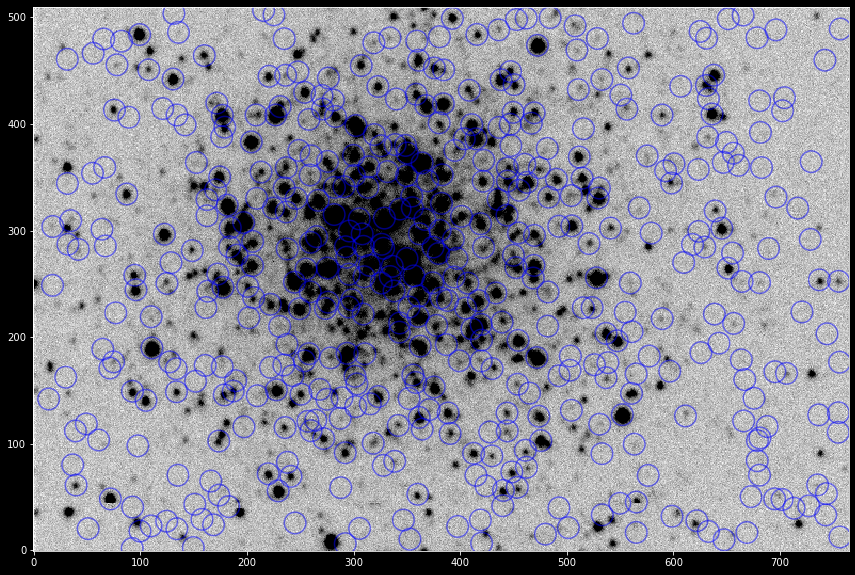

In [93]:
pl.figure(figsize=(15,10))
pl.imshow(sky_subtracted_M13_I, cmap='gray_r', origin='lower', vmax=150, vmin=-50)
_=apertures_V.plot(color='blue', lw=1.5, alpha=0.5)

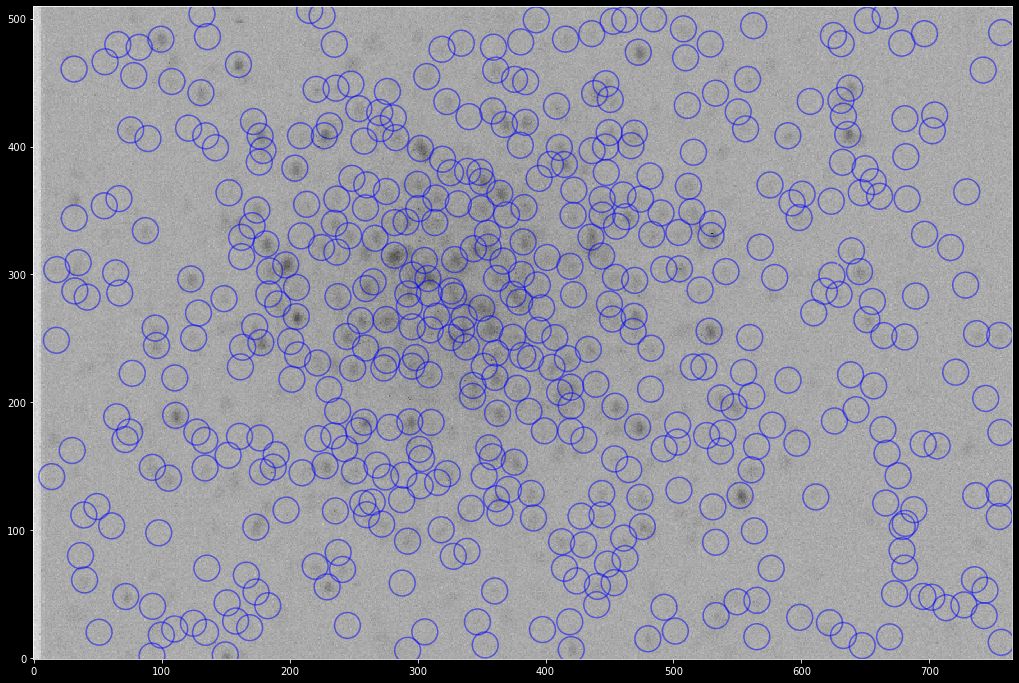

In [94]:
pl.figure(figsize=(20,12))
pl.imshow(sky_subtracted_M13_B, cmap='gray_r', origin='lower', vmax=400, vmin=-200)
_=apertures_V.plot(color='blue', lw=1.5, alpha=0.5)

In [95]:
phot_table_I = aperture_photometry(sky_subtracted_M13_I, apertures_V, error=M13_darksub_I_flattened_uncertainty)
for colname in phot_table_I.colnames:
    phot_table_I.rename_column(colname, "I_"+colname)
phot_table_B = aperture_photometry(sky_subtracted_M13_B, apertures_V, error=M13_darksub_B_flattened_uncertainty)
for colname in phot_table_B.colnames:
    phot_table_B.rename_column(colname, "B_"+colname)

In [96]:
full_table = table.hstack([sources_V, phot_table_V, phot_table_B, phot_table_I])
full_table

<QTable length=480>
  id      xcentroid      ...    I_aperture_sum   I_aperture_sum_err
                         ...                                       
int32      float64       ...       float64            float64      
----- ------------------ ... ------------------- ------------------
    1   92.2717243108516 ...  -314.2112760642735  235.2386724044741
    2 149.58758627052256 ...  1264.6331006790322 245.62307895944164
    3 292.13480479903023 ...   12585.44894558235  283.0920406893448
    4 420.05839991320664 ...   5151.014016190781  290.6048291049821
    5 352.81238705140515 ...   3577.973622944182 312.17018390448914
    6  647.5387236664527 ...   722.6648120231054  309.0986628730963
    7  756.2423495968503 ... -105.97848620953667 305.12769166643017
    8 479.94291754659145 ...   2739.469918750282  310.4989080543242
    9  668.9534157564451 ...  -786.3383255115065 308.48028193608167
  ...                ... ...                 ...                ...
  471  562.6747454129965 ...  1203.8062364621478 310.27780660790313
  472 461.89567364571013 ...  2194.5040667159133 301.80543186689073
  473   651.493439974115 ... -268.57983181324687 305.02062466277573
  474 452.84744323012615 ...   2992.184034598041 304.69788318001537
  475  484.3902332767347 ...    4917.55779959551  301.4368056997286
  476  392.7191433946665 ...  16660.425472608204 299.28001354258345
  477 225.24304147339615 ...   821.6045054200208 280.12596342318477
  478  665.4362547624455 ...  -430.4700025304179  291.2056580633471
  479 131.35366060776136 ...  -64.41454021533701  270.5050408731165
  480 215.54694194484887 ...   433.8239673929506 242.74498542459594

In [97]:
for col in full_table.colnames:  
    full_table[col].info.format = '%.3g'  # "%.3g" will print only 3 values, so it can be used for sig-fig display
full_table

<QTable length=480>
  id  xcentroid ycentroid ... I_ycenter I_aperture_sum I_aperture_sum_err
                          ...    pix                                     
int32  float64   float64  ...  float64     float64          float64      
----- --------- --------- ... --------- -------------- ------------------
    1      92.3      1.64 ...      1.64           -314                235
    2       150      2.54 ...      2.54       1.26e+03                246
    3       292      6.16 ...      6.16       1.26e+04                283
    4       420      6.67 ...      6.67       5.15e+03                291
    5       353      10.3 ...      10.3       3.58e+03                312
    6       648      9.79 ...      9.79            723                309
    7       756      12.4 ...      12.4           -106                305
    8       480      15.1 ...      15.1       2.74e+03                310
    9       669      16.7 ...      16.7           -786                308
  ...       ...       ... ...       ...            ...                ...
  471       563       494 ...       494        1.2e+03                310
  472       462       499 ...       499       2.19e+03                302
  473       651       499 ...       499           -269                305
  474       453       498 ...       498       2.99e+03                305
  475       484       500 ...       500       4.92e+03                301
  476       393       499 ...       499       1.67e+04                299
  477       225       502 ...       502            822                280
  478       665       502 ...       502           -430                291
  479       131       504 ...       504          -64.4                271
  480       216       506 ...       506            434                243

In [98]:
full_table['id',
           'V_aperture_sum', 'V_aperture_sum_err',
           'B_aperture_sum', 'B_aperture_sum_err',
           'I_aperture_sum', 'I_aperture_sum_err'].show_in_notebook()
# .pprint(max_lines=1000, max_width=1000)

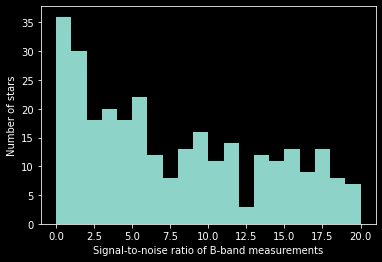

In [99]:
SNR_B = full_table['B_aperture_sum']/full_table['B_aperture_sum_err']
_=pl.hist(SNR_B, bins=np.linspace(0,20,21))
_=pl.xlabel("Signal-to-noise ratio of B-band measurements")
_=pl.ylabel("Number of stars")

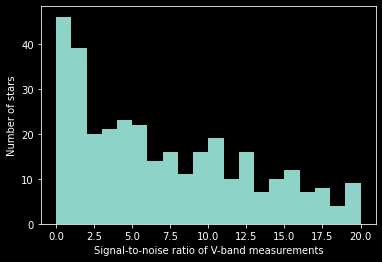

In [100]:
SNR_V = full_table['V_aperture_sum']/full_table['V_aperture_sum_err']
_=pl.hist(SNR_V, bins=np.linspace(0,20,21))
_=pl.xlabel("Signal-to-noise ratio of V-band measurements")
_=pl.ylabel("Number of stars")

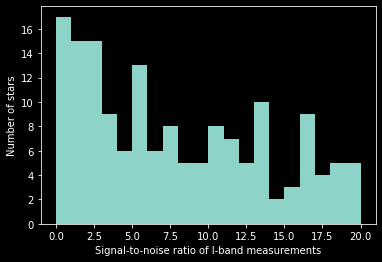

In [101]:
SNR_I = full_table['I_aperture_sum']/full_table['I_aperture_sum_err']
_=pl.hist(SNR_I, bins=np.linspace(0,20,21))
_=pl.xlabel("Signal-to-noise ratio of I-band measurements")
_=pl.ylabel("Number of stars")

In [102]:
high_snr = (SNR_B > 5) & (SNR_V > 5) & (SNR_I > 5)
high_snr.sum()

298

In [103]:
full_table['id',
           'V_aperture_sum', 'V_aperture_sum_err',
           'B_aperture_sum', 'B_aperture_sum_err',
           'I_aperture_sum', 'I_aperture_sum_err'][high_snr].show_in_notebook()

In [104]:
# we measure the magnitude zeropoints earlier...
I_magzero = avg_zpI
V_magzero = avg_zpV
B_magzero = avg_zpB

Imag = -2.5 * np.log10(full_table['I_aperture_sum']) + I_magzero + 2.5*np.log10(20)
Vmag = -2.5 * np.log10(full_table['V_aperture_sum']) + V_magzero + 2.5*np.log10(20)
Bmag = -2.5 * np.log10(full_table['B_aperture_sum']) + B_magzero + 2.5*np.log10(20)

eImag = 1.09 * full_table['I_aperture_sum_err']/full_table['I_aperture_sum']
eVmag = 1.09 * full_table['V_aperture_sum_err']/full_table['V_aperture_sum']
eBmag = 1.09 * full_table['B_aperture_sum_err']/full_table['B_aperture_sum']

<ipython-input-104-7b8953fed7df>:6: RuntimeWarning: invalid value encountered in log10
  Imag = -2.5 * np.log10(full_table['I_aperture_sum']) + I_magzero + 2.5*np.log10(20)
<ipython-input-104-7b8953fed7df>:7: RuntimeWarning: invalid value encountered in log10
  Vmag = -2.5 * np.log10(full_table['V_aperture_sum']) + V_magzero + 2.5*np.log10(20)
<ipython-input-104-7b8953fed7df>:8: RuntimeWarning: invalid value encountered in log10
  Bmag = -2.5 * np.log10(full_table['B_aperture_sum']) + B_magzero + 2.5*np.log10(20)


In [105]:
full_table.add_column(Imag, name='M_I')
full_table.add_column(eImag, name='eM_I')
full_table.add_column(Vmag, name='M_V')
full_table.add_column(eVmag, name='eM_V')
full_table.add_column(Bmag, name='M_B')
full_table.add_column(eBmag, name='eM_B')
for col in full_table.colnames:  
    full_table[col].info.format = '%.3g'  # "%.3g" will print only 3 values, so it can be used for sig-fig display

In [106]:
full_table['id',
           'M_I', 'eM_I',
           'M_V', 'eM_V',
           'M_B', 'eM_B'][high_snr].show_in_notebook()

In [107]:
full_table.write('M13_photometry_table.fits', overwrite=True)

Text(0, 0.5, 'V magnitude')

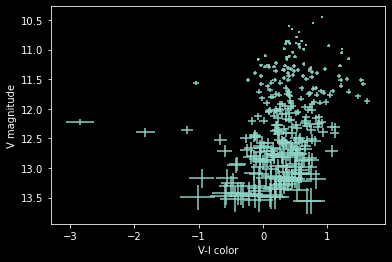

In [108]:
pl.errorbar((Vmag-Imag)[high_snr], Vmag[high_snr],
            xerr=((eImag**2+eVmag**2)**0.5)[high_snr],
            yerr=eVmag[high_snr], linestyle='none')
pl.gca().invert_yaxis()
pl.xlabel("V-I color")
pl.ylabel("V magnitude")

Text(0, 0.5, 'V magnitude')

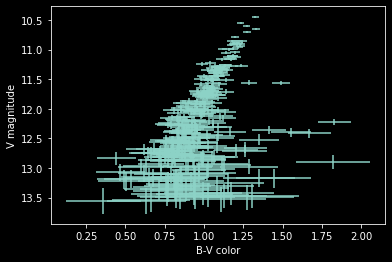

In [109]:
pl.errorbar((Bmag-Vmag)[high_snr], Vmag[high_snr],
            xerr=((eBmag**2+eVmag**2)**0.5)[high_snr],
            yerr=eVmag[high_snr], linestyle='none')
pl.gca().invert_yaxis()
pl.xlabel("B-V color")
pl.ylabel("V magnitude")

Text(0, 0.5, 'I magnitude')

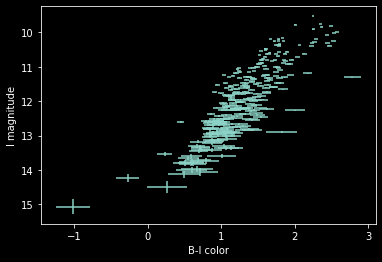

In [110]:
pl.errorbar((Bmag-Imag)[high_snr], Imag[high_snr],
            xerr=((eBmag**2+eImag**2)**0.5)[high_snr],
            yerr=eImag[high_snr], linestyle='none')
pl.gca().invert_yaxis()
pl.xlabel("B-I color")
pl.ylabel("I magnitude")

Text(0, 0.5, 'B magnitude')

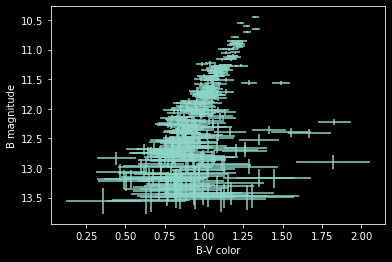

In [153]:
pl.errorbar((Bmag-Vmag)[high_snr], Vmag[high_snr],
            xerr=((eBmag**2+eVmag**2)**0.5)[high_snr],
            yerr=eVmag[high_snr], linestyle='none')
pl.gca().invert_yaxis()
pl.xlabel("B-V color")
pl.ylabel("B magnitude")

Text(0, 0.5, 'V-I color')

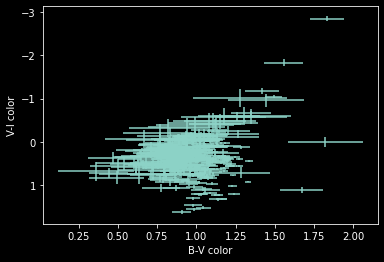

In [154]:
pl.errorbar((Bmag-Vmag)[high_snr], (Vmag-Imag)[high_snr],
            xerr=((eBmag**2+eVmag**2)**0.5)[high_snr],
            yerr=eVmag[high_snr], linestyle='none')
pl.gca().invert_yaxis()
pl.xlabel("B-V color")
pl.ylabel("V-I color")

In [112]:
red_stars = (Vmag-Imag) > 0.3

In [113]:
# we make an RGB image...
rgb_image = np.array([sky_subtracted_M13_I, sky_subtracted_M13_V, sky_subtracted_M13_B]).T.swapaxes(0,1)
rgb_image = (rgb_image - np.percentile(rgb_image, 10, axis=(0,1)))
rgb_image = np.log10(rgb_image)
rgb_image[np.isnan(rgb_image)] = 0
rgb_image /= np.percentile(rgb_image, 99.95)

<ipython-input-113-27bdf116f3c9>:4: RuntimeWarning: invalid value encountered in log10
  rgb_image = np.log10(rgb_image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


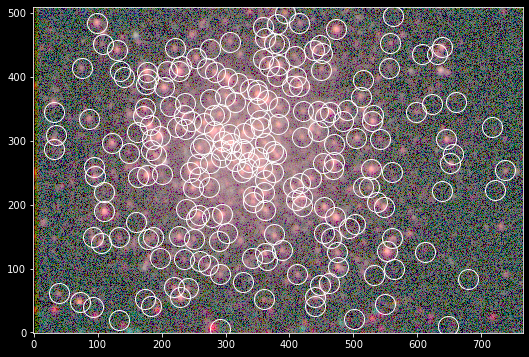

In [114]:
pl.figure(figsize=(10,6))
pl.imshow(rgb_image)
pl.plot(full_table[red_stars]['xcentroid'], full_table[red_stars]['ycentroid'], 'o', mfc='none', mec='white', markersize=20)

In [115]:
distance_modulus = 5 * np.log10(7700) - 5
distance_modulus

14.432453625862408

In [116]:
os.chdir("C:\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 1\\AST3722-Fall-2021-09-29-21")

In [117]:
#os.chdir("C:\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 1\\In CLass\\Centroids")

In [118]:
isochrone1= Table.read('isochrones_av0p12_feh_m1p54.dat', format='ascii')
#isochrone1 = Table.read('isochrones_av0p12_feh_m1p54.dat', format='ascii', header_start=12, data_start=13)
isochrone1.sort('Vmag')


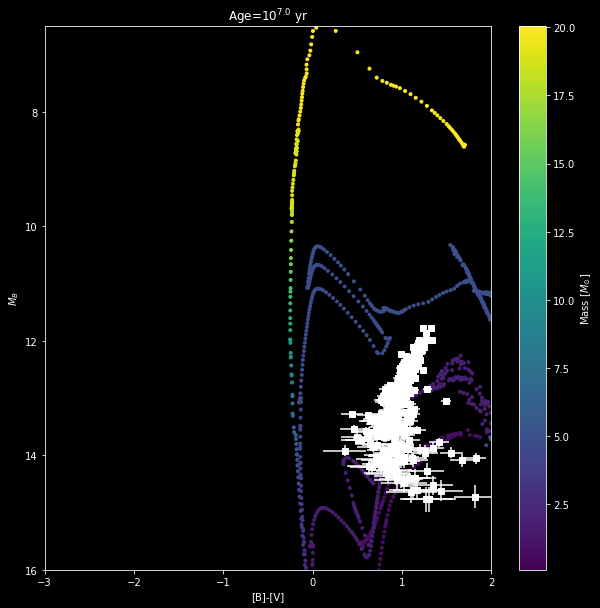

In [119]:
pl.figure(figsize=(10,10))
pl.scatter(isochrone1['Bmag'] - isochrone1['Vmag'],
           isochrone1['Bmag'] + distance_modulus,
           c=isochrone1['Mini'],
           marker='.')
pl.errorbar((Bmag-Vmag)[high_snr], Bmag[high_snr],
            xerr=((eBmag**2+eVmag**2)**0.5)[high_snr],
            yerr=eBmag[high_snr], linestyle='none', color='w', marker='s')
pl.ylim(16,6.5); pl.ylabel("$M_B$")
pl.xlim(-3,2); pl.xlabel("[B]-[V]")
pl.title(f'Age=$10^{{{isochrone1["logAge"][0]}}}$ yr')
cb = pl.colorbar()
cb.set_label("Mass [$M_{\odot}$]")

In [120]:
#os.chdir("C:\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 1\\In CLass\\Centroids")

In [121]:
isochrone2= Table.read('isochrones_av0p12_feh_m1p54.dat', format='ascii')
#isochrone1 = Table.read('isochrones_av0p12_feh_m1p54.dat', format='ascii', header_start=12, data_start=13)
isochrone2.sort('Vmag')
isochrone2.sort('logAge')
isochrone_100Myr = isochrone2[isochrone2['logAge'] == 8]
isochrone_1Gyr = isochrone2[isochrone2['logAge'] == 9]
isochrone_10Gyr = isochrone2[isochrone2['logAge'] == 10]

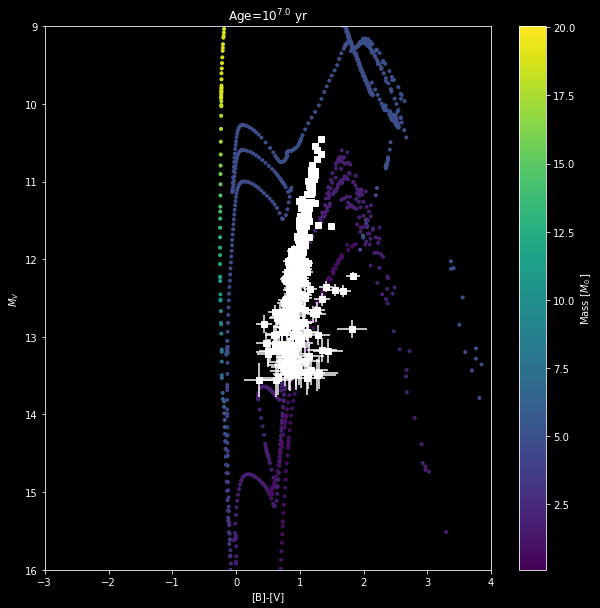

In [122]:
pl.figure(figsize=(10,10))
pl.scatter(isochrone2['Bmag'] - isochrone2['Vmag'],
           isochrone2['Vmag'] + distance_modulus,
           c=isochrone2['Mini'],
           marker='.')
pl.errorbar((Bmag-Vmag)[high_snr], Vmag[high_snr],
            xerr=((eBmag**2+eVmag**2)**0.5)[high_snr],
            yerr=eVmag[high_snr], linestyle='none', color='w', marker='s')
pl.ylim(16,9); pl.ylabel("$M_V$")
pl.xlim(-3,4); pl.xlabel("[B]-[V]")
pl.title(f'Age=$10^{{{isochrone2["logAge"][0]}}}$ yr')
cb = pl.colorbar()
cb.set_label("Mass [$M_{\odot}$]")

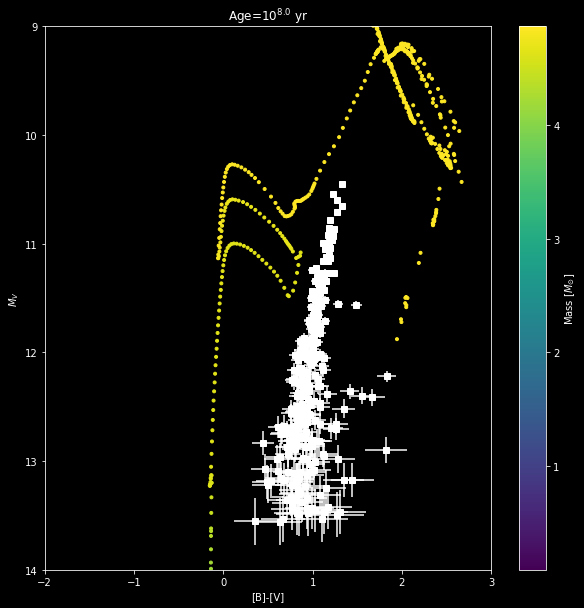

In [123]:
pl.figure(figsize=(10,10))
pl.scatter(isochrone_100Myr['Bmag'] - isochrone_100Myr['Vmag'],
           isochrone_100Myr['Vmag'] + distance_modulus,
           c=isochrone_100Myr['Mini'],
           marker='.')
pl.errorbar((Bmag-Vmag)[high_snr], Vmag[high_snr],
            xerr=((eBmag**2+eVmag**2)**0.5)[high_snr],
            yerr=eVmag[high_snr], linestyle='none', color='w', marker='s')
pl.ylim(14,9); pl.ylabel("$M_V$")
pl.xlim(-2,3); pl.xlabel("[B]-[V]")
pl.title(f'Age=$10^{{{isochrone_100Myr["logAge"][0]}}}$ yr')
cb = pl.colorbar()
cb.set_label("Mass [$M_{\odot}$]")

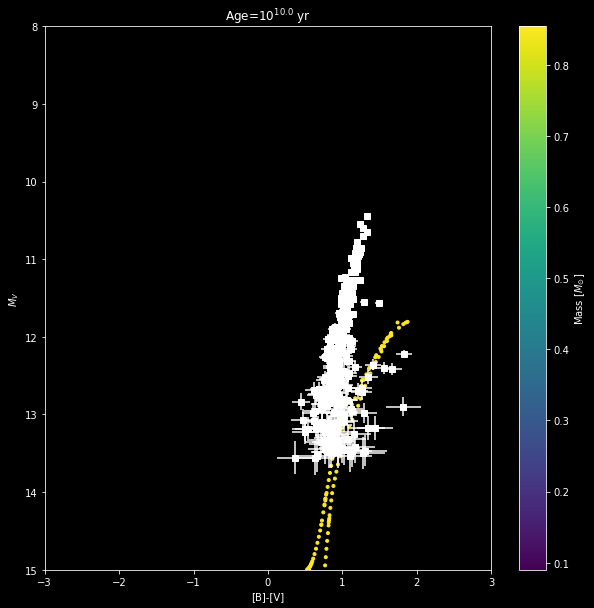

In [124]:
pl.figure(figsize=(10,10))
pl.scatter(isochrone_10Gyr['Bmag'] - isochrone_10Gyr['Vmag'],
           isochrone_10Gyr['Vmag'] + distance_modulus,
           c=isochrone_10Gyr['Mini'],
           marker='.')
pl.errorbar((Bmag-Vmag)[high_snr], Vmag[high_snr],
            xerr=((eBmag**2+eVmag**2)**0.5)[high_snr],
            yerr=eVmag[high_snr], linestyle='none', color='w', marker='s')
pl.ylim(15,8); pl.ylabel("$M_V$")
pl.xlim(-3,3); pl.xlabel("[B]-[V]")
pl.title(f'Age=$10^{{{isochrone_10Gyr["logAge"][0]}}}$ yr')
cb = pl.colorbar()
cb.set_label("Mass [$M_{\odot}$]")

In [125]:
os.chdir("C:\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 1\\AST3722-Fall-2021-09-29-21")

# Planets

In [126]:
saturn_darksub_V_flattened = fits.getdata('saturn_V_darksub_flattened.FIT') ## swapped
saturn_darksub_V_flattened_uncertainty = fits.getdata('saturn_V_darksub_flattened_uncertainty.FIT')

saturn_darksub_I_flattened = fits.getdata('saturn_I_darksub_flattened.FIT')
saturn_darksub_I_flattened_uncertainty = fits.getdata('saturn_I_darksub_flattened_uncertainty.FIT')

saturn_darksub_B_flattened = fits.getdata('saturn_B_darksub_flattened.FIT') ## swapped 
saturn_darksub_B_flattened_uncertainty = fits.getdata('saturn_B_darksub_flattened_uncertainty.FIT')

In [127]:
jupiter_darksub_V_flattened = fits.getdata('jupiter_V_darksub_flattened.FIT') ## swapped
jupiter_darksub_V_flattened_uncertainty = fits.getdata('jupiter_V_darksub_flattened_uncertainty.FIT')

jupiter_darksub_I_flattened = fits.getdata('jupiter_I_darksub_flattened.FIT')
jupiter_darksub_I_flattened_uncertainty = fits.getdata('jupiter_I_darksub_flattened_uncertainty.FIT')

jupiter_darksub_B_flattened = fits.getdata('jupiter_B_darksub_flattened.FIT') ## swapped 
jupiter_darksub_B_flattened_uncertainty = fits.getdata('jupiter_B_darksub_flattened_uncertainty.FIT')

In [128]:
background_stddev = np.median(saturn_darksub_V_flattened_uncertainty)
background_stddev

15.859535280234565

In [146]:
total_counts_B_jup = 4.59e+07
total_counts_V_jup = 1.24e+08
total_counts_I_jup = 9.11e+07

total_counts_B_sat = 1.78e+07
total_counts_V_sat = 2.2e+07
total_counts_I_sat = 2.47e+07

count_error_B_jup = 3113.522483809833
count_error_V_jup = 5107.312267779638
count_error_I_jup = 4365.369687493648

count_error_B_sat = 4.46e+03
count_error_V_sat = 5.5e+03
count_error_I_sat = 6.19e+03

In [159]:
Imag_jup = -2.5 * np.log10(total_counts_I_jup) + 30 + 2.5*np.log10(0.04)
Vmag_jup = -2.5 * np.log10(total_counts_V_jup) + 30 + 2.5*np.log10(0.04)
Bmag_jup = -2.5 * np.log10(total_counts_B_jup) + 30 + 2.5*np.log10(0.04)


eImag_jup = 1.09 * count_error_I_jup/total_counts_I_jup
eVmag_jup = 1.09 * count_error_V_jup/total_counts_V_jup
eBmag_jup = 1.09 * count_error_B_jup/total_counts_B_jup

In [157]:
Imag_sat= -2.5 * np.log10(total_counts_I_sat) + 30 + 2.5*np.log10(0.04)
Vmag_sat= -2.5 * np.log10(total_counts_V_sat) + 30 + 2.5*np.log10(0.04)
Bmag_sat= -2.5 * np.log10(total_counts_B_sat) + 30 + 2.5*np.log10(0.04)


eImag_sat = 1.09 * count_error_I_sat/total_counts_I_sat
eVmag_sat = 1.09 * count_error_V_sat/total_counts_V_sat
eBmag_sat = 1.09 * count_error_B_sat/total_counts_B_sat

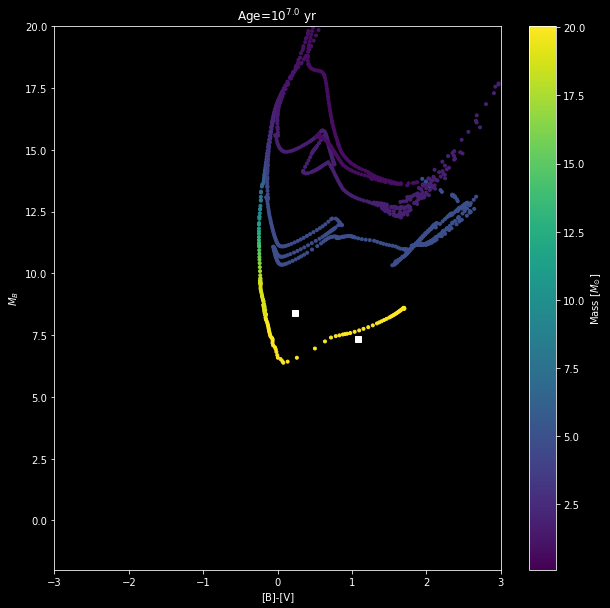

In [162]:
pl.figure(figsize=(10,10))
pl.scatter(isochrone2['Bmag'] - isochrone2['Vmag'],
           isochrone2['Bmag'] + distance_modulus,
           c=isochrone2['Mini'],
           marker='.')
pl.errorbar((Bmag_jup-Vmag_jup), Bmag_jup,
            xerr=((eBmag_jup**2+eVmag_jup**2)**0.5),
            yerr=eBmag_jup, linestyle='none', color='w', marker='s')
pl.errorbar((Bmag_sat-Vmag_sat), Bmag_sat,
            xerr=((eBmag_sat**2+eVmag_sat**2)**0.5),
            yerr=eBmag_sat, linestyle='none', color='w', marker='s')
pl.ylim(-2,20); pl.ylabel("$M_B$")
pl.xlim(-3,3); pl.xlabel("[B]-[V]")
pl.title(f'Age=$10^{{{isochrone2["logAge"][0]}}}$ yr')
cb = pl.colorbar()
cb.set_label("Mass [$M_{\odot}$]")

In [ ]:
pl.errorbar((Bmag-Vmag)[high_snr], (Vmag-Imag)[high_snr],
            xerr=((eBmag**2+eImag**2)**0.5)[high_snr],
            yerr=eImag[high_snr], linestyle='none')
pl.gca().invert_yaxis()
pl.xlabel("B-V color")
pl.ylabel("V-I color")

In [ ]:
pl.errorbar((Bmag-Vmag)[high_snr], Vmag[high_snr],
            xerr=((eBmag**2+eVmag**2)**0.5)[high_snr],
            yerr=eVmag[high_snr], linestyle='none')

pl.errorbar((Bmag_jup-Vmag_jup), Vmag_jup,
            xerr=((eBmag_jup**2+eVmag_jup**2)**0.5),
            yerr=eBmag_jup, linestyle='none', color='w', marker='s')
pl.errorbar((Bmag_sat-Vmag_sat), Vmag_sat,
            xerr=((eBmag_sat**2+eVmag_sat**2)**0.5),
            yerr=eBmag_sat, linestyle='none', color='w', marker='s')
pl.gca().invert_yaxis()
pl.xlabel("B-V color")
pl.ylabel("B magnitude")